In [1]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
from obspy import UTCDateTime
import sys
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import matplotlib.pyplot as plt
import matplotlib
import os

In [12]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))
        st.resample(50)

        st.detrend('linear')
        st.taper(max_percentage=None,max_length=5, type='hann') #max_length in sec
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
                
        st.merge(fill_value=0)
        print(':) year={}, jday={}, net={}, sta={}, cha={}'.format(year,jday, net, sta, cha))
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [3]:
def read_stream(net, stn, chn, year, jday):
    st = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network='{}'.format(net), station='{}'.format(stn), channel='{}'.format(chn),
                                       year='{}'.format(year), doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        #st.taper(0.45) # find a good value!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    except:
        print('pass {}'.format(jday))
    return(st)

:) year=2004, jday=110, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=111, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=112, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=113, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=114, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=115, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=116, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=117, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=118, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=119, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=120, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=121, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=122, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=123, net=UW, sta=CDF, cha=EHZ


/home/koepflma/anaconda3/envs/seismo/lib/python3.8/site-packages/obspy/core/trace.py:2157: UserWarning: The requested taper is longer than the trace. The taper will be shortened to trace length.
  warnings.warn(msg)


:) year=2004, jday=124, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=125, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=126, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=127, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=128, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=129, net=UW, sta=CDF, cha=EHZ
:) year=2004, jday=130, net=UW, sta=CDF, cha=EHZ


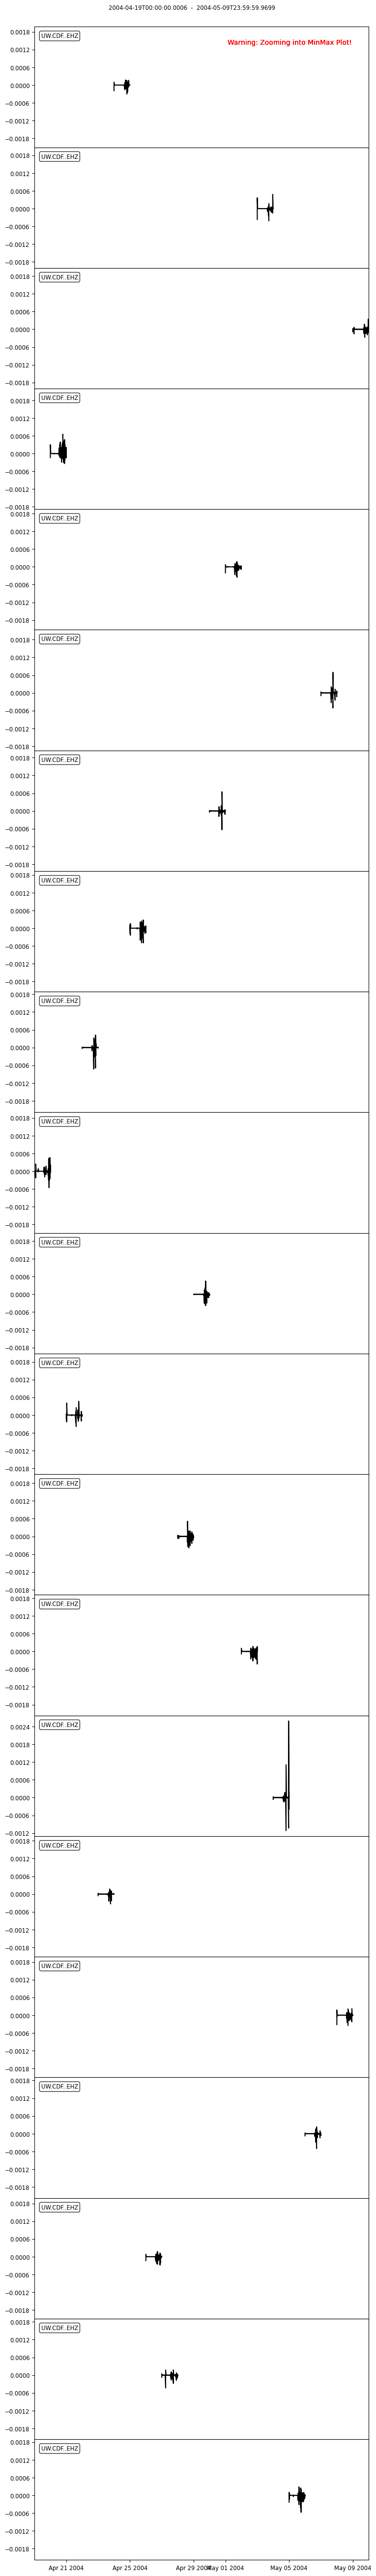

21 Trace(s) in Stream:

UW.CDF..EHZ | 2004-04-19T00:00:00.000600Z - 2004-04-19T23:59:59.980600Z | 50.0 Hz, 4320000 samples
...
(19 other traces)
...
UW.CDF..EHZ | 2004-05-09T00:00:00.009900Z - 2004-05-09T23:59:59.969900Z | 50.0 Hz, 4319999 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [18]:
net = 'UW'
sta = 'CDF'
cha = 'EHZ'
year = 2004
jdays = range(110,130+1)
#jdays = range(267,287+1)
#jdays = ['162', '161']
stst = obspy.Stream()
for jday in jdays:
    st_read = preprocessing(year,jday, net, sta, cha)
    stst += st_read
stst.plot()
stst

:) year=1980, jday=110, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=111, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=112, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=113, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=114, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=115, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=116, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=117, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=118, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=119, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=120, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=121, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=122, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=123, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=124, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=125, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=126, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=127, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=128, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=129, net=UW, sta=CDF, cha=SHZ
:) year=1980, jday=1

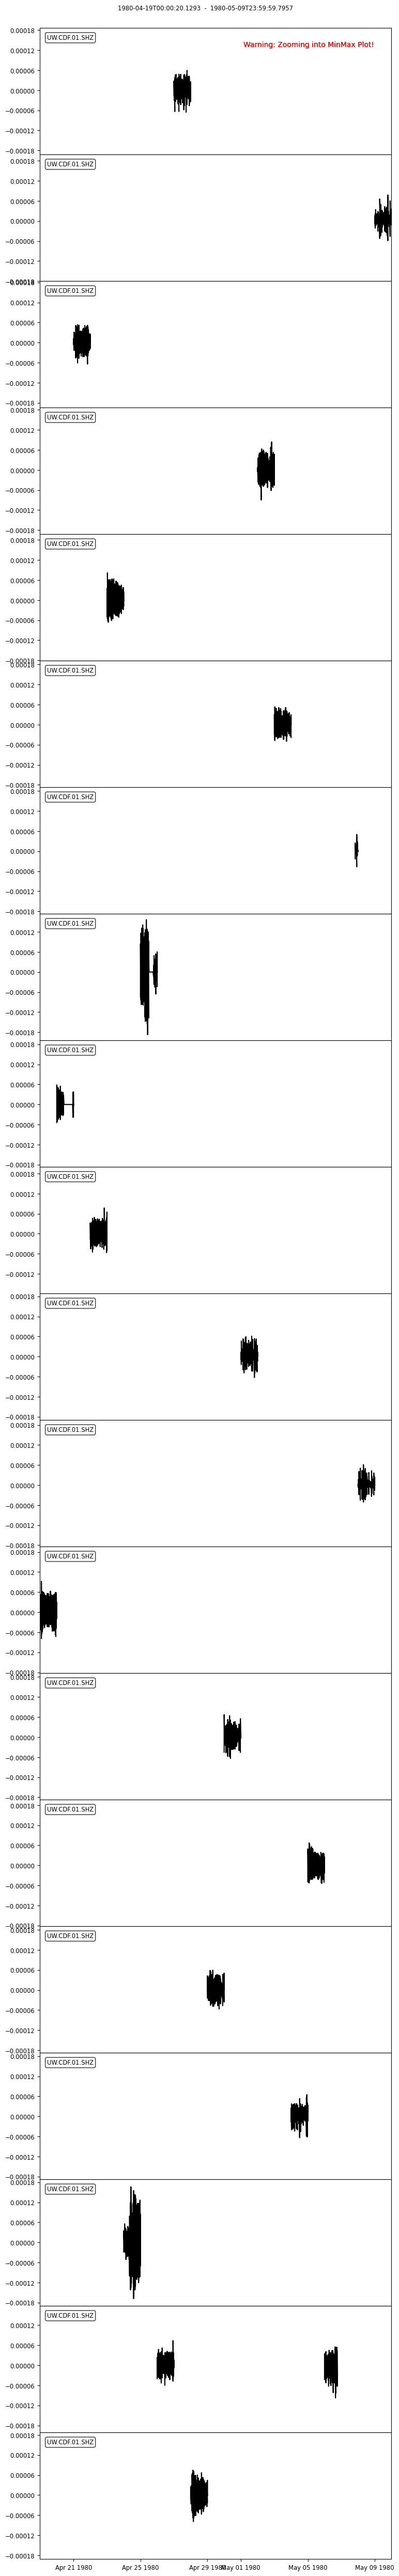

21 Trace(s) in Stream:

UW.CDF.01.SHZ | 1980-04-19T00:00:20.129300Z - 1980-04-19T23:59:59.629300Z | 50.0 Hz, 4318976 samples
...
(19 other traces)
...
UW.CDF.01.SHZ | 1980-05-09T00:00:20.175700Z - 1980-05-09T23:59:59.795700Z | 50.0 Hz, 4318982 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [13]:
net = 'UW'
sta = 'CDF'
cha = 'SHZ'
year = 1980
jdays = range(110,130+1)
#jdays = range(267,287+1)
#jdays = ['162', '161']
st = obspy.Stream()
for jday in jdays:
    st_read = preprocessing(year,jday, net, sta, cha)
    st += st_read
st.plot()
st

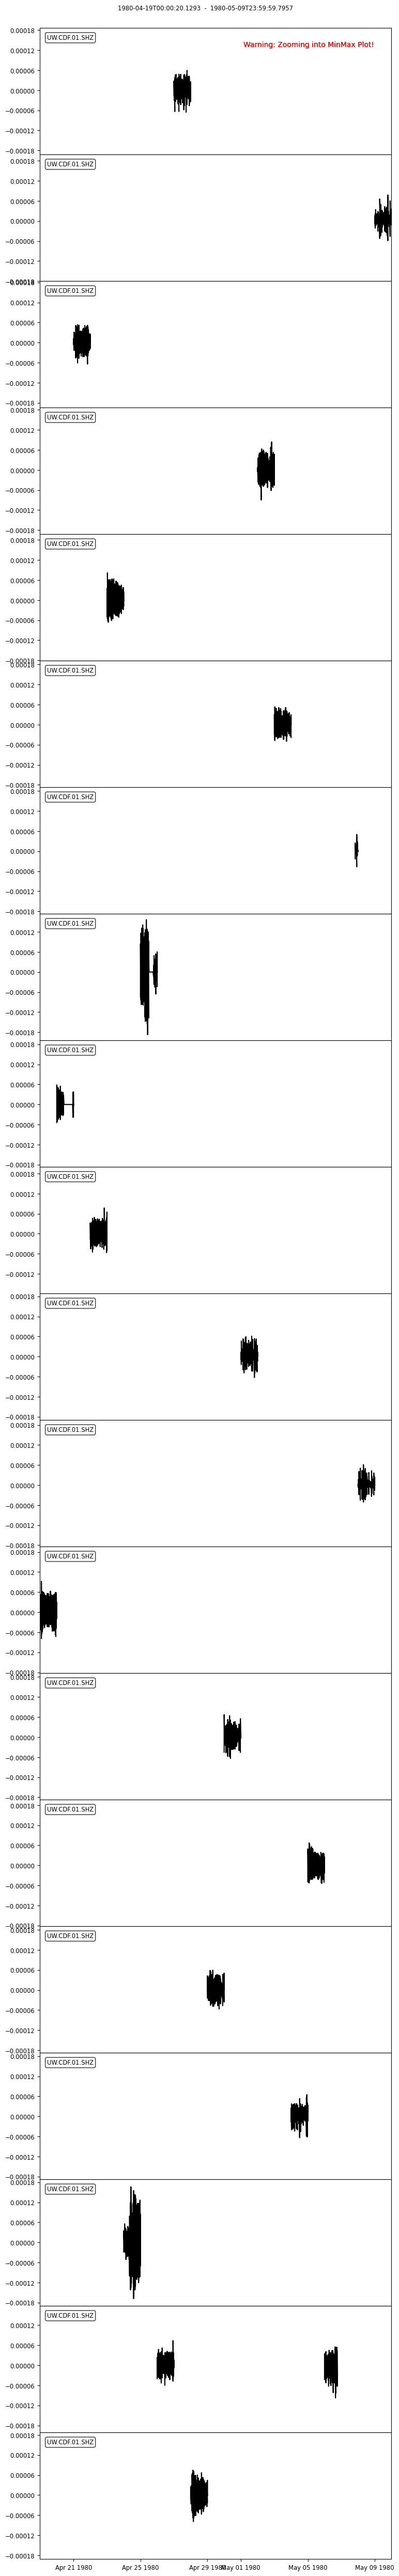

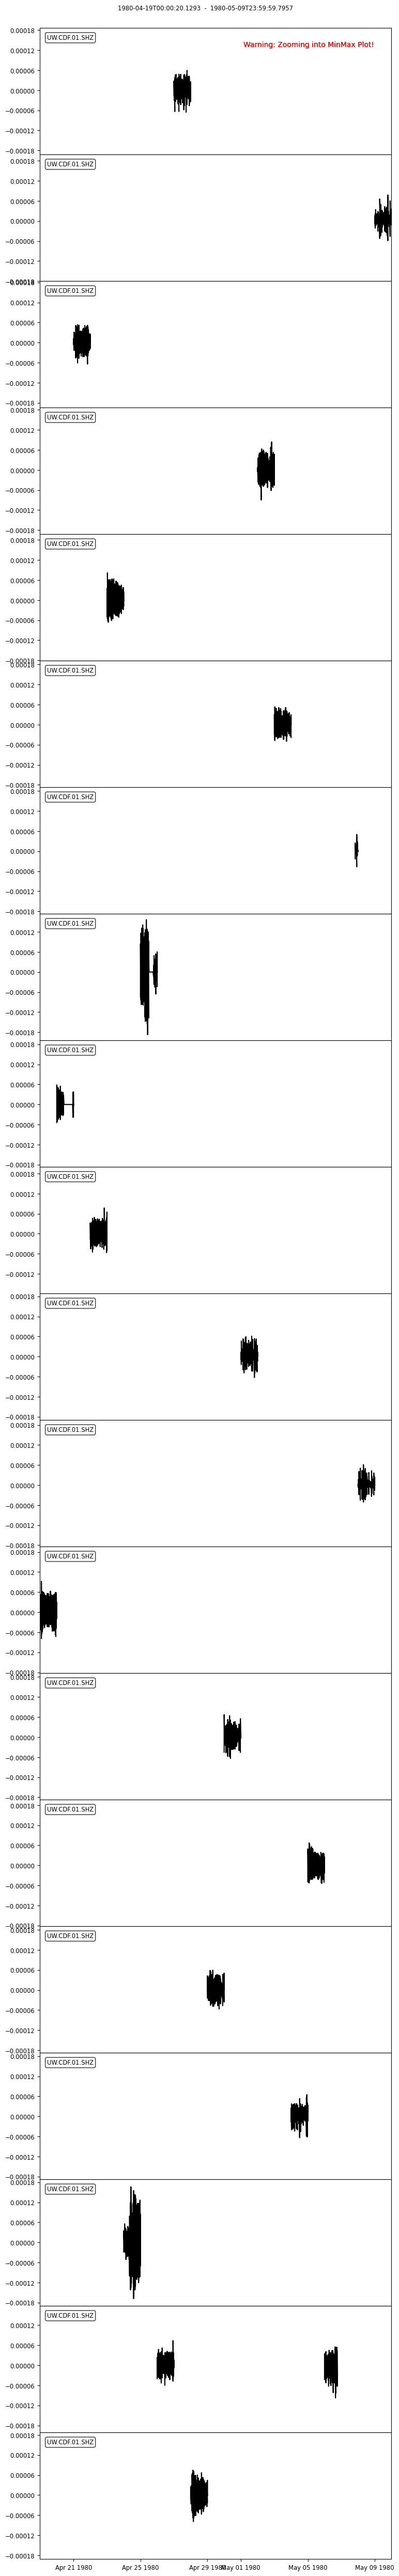

In [17]:
st.plot()

In [34]:
st_merge = st_copy.merge()

In [33]:
st_copy = st.copy()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


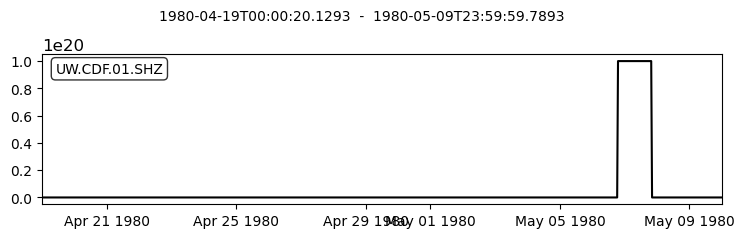

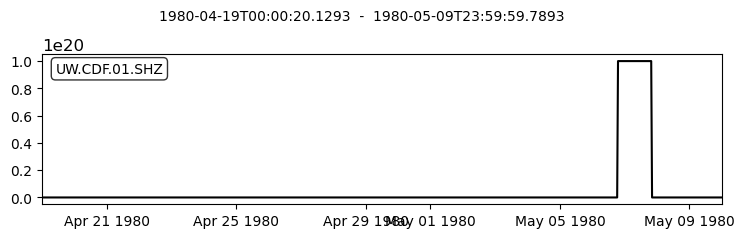

In [35]:
st_merge.plot()

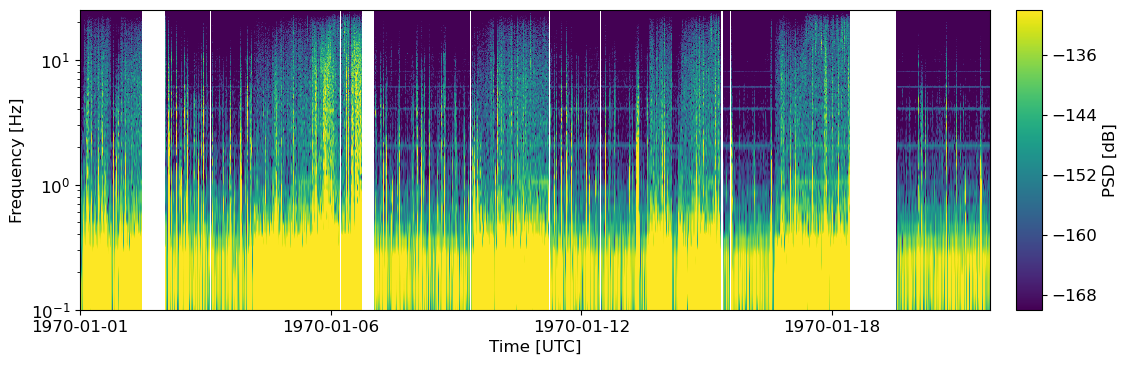

In [29]:

# frequenc filter
#fmin = 19
#fmax = 41
#st.filter('bandpass', freqmin=fmin, freqmax=fmax)
st = st.merge()
tr = st[0] #only get one obspy trace from obspy stream
s_date = tr.stats.starttime.date
e_date = tr.stats.endtime.date
data = tr.data #extract numpy data array from obspy trace

data = data/1. #extract numpy data array from obspy trace and convert to float   
# if len(loc) !=0:  
#     index = stn+'.'+loc
# else:
#     index = stn

# convert data from counts to velocity
# data = data / df_sens.loc[index][0] #V/(m/s) sensitivity
# data = data / df_sens.loc[index][1] #cnts/V


fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 10 #bin size for fourier transform. Type in length in seconds [for a day 100, for an hour 10]

fig = plt.figure(figsize=(13,5)) #create figure and add axes to it 13,5 od 10,5
ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.60]) #[left bottom width height]
ax2 = fig.add_axes([0.82, 0.1, 0.02, 0.6])

#plot spectrogram on first axis
Pxx, freqs, bins, im = ax1.specgram(data, NFFT=int(NFFT), Fs=fs, 
                                    noverlap=fs*0, #overlap of bins in samples
                                    detrend='linear', #detrending before taking fourier transform
                                    mode='psd', #'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, #unit/Hz
                                    scale='dB', #'linear', 'dB'
                                    cmap='viridis', #your favourite colormap
                                    vmin=-170, #-25
                                    vmax=-130#, #50
#                                     xextent=[tr.stats.starttime.timestamp, 
#                                              tr.stats.endtime.timestamp]
                                   )

#show the date and time in the x-ticks
my_times = [(tr.stats.starttime + i).timestamp for i in bins]
def timeTicks(my_times, pos):                                                                                                                                                                                                                                                         
    return datetime.datetime.utcfromtimestamp(my_times).strftime("%Y-%m-%d") # %Y-%m-%d:%H:%M:%S                                                                                                                                                                                                                                                                                
formatter = matplotlib.ticker.FuncFormatter(timeTicks)   
ax1.xaxis.set_major_formatter(formatter) 
#ax1.tick_params(axis='x', rotation=45)
ax1.locator_params(axis='x', nbins=7)

#ax1.set_yscale('log') #uncomment for logarithmic y-scale
# ax1.set_title('{} - {} {}.{}'.format(s_date,e_date,stn,chn), fontsize=14)
ax1.set_xlabel('Time [UTC]', fontsize=12) #x-label 
ax1.set_ylabel('Frequency [Hz]', fontsize=12) #y-label
ax1.tick_params(axis='both', labelsize=12) 
ax1.set_ylim([0.1,25]) #be carefull with lower limit when y-scale is logarithmic
ax1.set_yscale('log')

cbar = plt.colorbar(im, cax=ax2) #map colorbar to image (output of specgram), plot it on ax2
cbar.set_label('PSD [dB]', fontsize=12) #colorbar label   Intensity
cbar.locator = matplotlib.ticker.MaxNLocator(nbins=6) # amount of ticks of the colorbar (Anzahl beschriftungen des colbar)
cbar.update_ticks()

# save_dir = 'test_{}'.format(day)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

#plt.savefig(save_dir+'/{}.{}_{}.png'.format(stn,loc,chn),bbox_inches='tight', dpi=300) # RA9x
#plt.savefig(save_dir+'/neu_{}_{}.png'.format(stn,chn),bbox_inches='tight', dpi=300) # RA8x
# plt.savefig(save_dir+'/{}_{}.{}_{}.png'.format(day,stn,loc,chn),bbox_inches='tight',dpi=300)

#sys.stdout.write('\r{} of {}'.format(i, len(stalocchaday)))
#sys.stdout.flush()


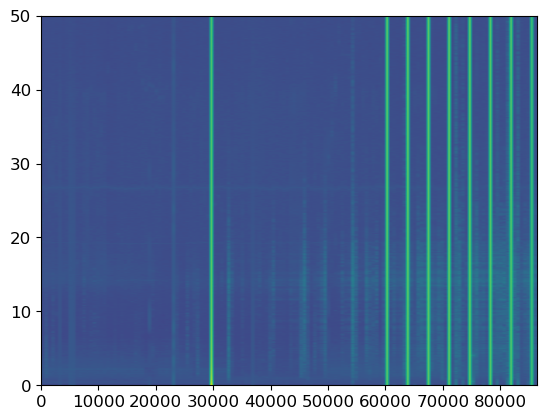

In [11]:
# frequenc filter
#fmin = 19
#fmax = 41
#st.filter('bandpass', freqmin=fmin, freqmax=fmax)
st = st.merge()
tr = st[0] #only get one obspy trace from obspy stream
s_date = tr.stats.starttime.date
e_date = tr.stats.endtime.date
data = tr.data #extract numpy data array from obspy trace

data = data/1. #extract numpy data array from obspy trace and convert to float   
# if len(loc) !=0:  
#     index = stn+'.'+loc
# else:
#     index = stn

# convert data from counts to velocity
# data = data / df_sens.loc[index][0] #V/(m/s) sensitivity
# data = data / df_sens.loc[index][1] #cnts/V

fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 600 #bin size for fourier transform. Type in length in seconds [for a day 100, for an hour 10]

#plot spectrogram on first axis
Pxx, freqs, bins, _ = plt.specgram(data, NFFT=int(NFFT), Fs=fs, 
                                    noverlap=fs*0, #overlap of bins in samples
                                    detrend='linear', #detrending before taking fourier transform
                                    mode='psd', #'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True #unit/Hz
                                   )

In [8]:
# time resampling
from scipy.interpolate import interp1d
t_bins = [(tr.stats.starttime+i).timestamp for i in bins]

# !!! set time resolution here !!!
dt = 60*60 # in seconds
t_bins_out = np.arange(t_bins[0], t_bins[-1], dt)
# determine datagaps
nodatagap = np.all(~np.isnan(Pxx), axis=0)
f_restime = interp1d(np.array(t_bins)[nodatagap], Pxx[:,nodatagap], axis=1)
Pxx_res1 = f_restime(t_bins_out) 

# frequency resampling
# !!! set frequency resolution here !!!
df = 0.01 #Hz
freqs_out = np.arange(freqs[0], freqs[-1], df)
f_resfreq = interp1d(freqs, Pxx_res1, axis=0)
Pxx_res2 = f_resfreq(freqs_out) 

NameError: name 'Pxx_res2' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


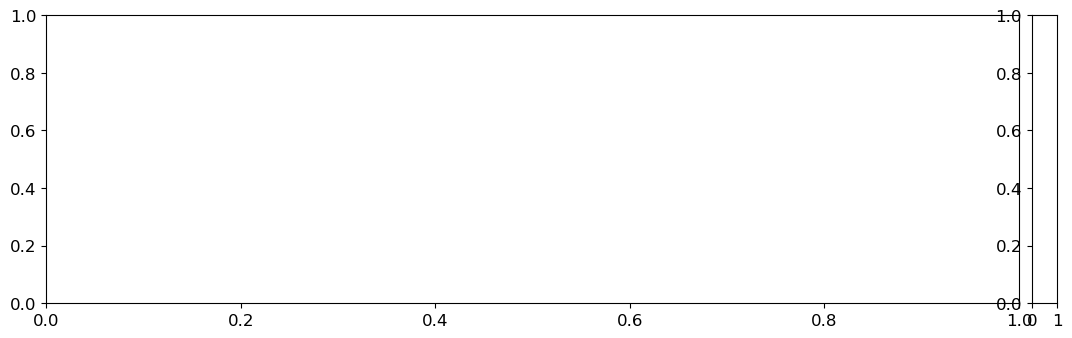

In [27]:
# plot
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['font.sans-serif'] = ['Verdana']

fig = plt.figure(figsize=(6.4*2,4.8))
ax1 = fig.add_axes([0.125, 0.125, 0.76, 0.6])
ax_cbar = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar


im = ax1.imshow(10*np.log10(Pxx_res2), aspect='auto', origin='lower', cmap="inferno",
            extent=[t_bins_out[0], t_bins_out[-1],0,np.max(freqs_out)],
#            vmax=np.percentile(10*np.log10(Pxx_res2),99.9),
#            vmin=np.percentile(10*np.log10(Pxx_res2),1)
            vmax=60, vmin=0
                 )

cbar = plt.colorbar(im, cax=ax_cbar)
cbar.ax.locator_params(nbins=5)
cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label

# ax1.set_yscale('log')
# ax1.set_ylim(0.1,np.max(freqs_out))
ax1.set_ylim(0,30)

# ===== x axes =====
stime = UTCDateTime(t_bins_out[0]).datetime
etime = UTCDateTime(t_bins_out[-2]).datetime

n_ticks = 8 # 8 x-ticks
h_ticks = 24 * np.round((etime-stime).days/8)
h_int = 24*3 #24h * 3d
daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
# x_ticks_str = [t.strftime('%-d %b %-Hh') for t in x_ticks_timestamps]
x_ticks_str = [t.strftime('%-d %b') for t in daterange]
x_tickloc = [UTCDateTime(t).timestamp for t in daterange]
ax1.set_xticks(x_tickloc)
ax1.set_xticklabels(x_ticks_str)
ax1.set_xlim(t_bins_out[0], t_bins_out[-1])

ax1.set_xlabel('Date in {}'.format(tr.stats.starttime.year))
ax1.set_ylabel('Frequency [Hz]')

# # ===== save figure =====
# save_path = 'spectrogram/{}/{}/multiday/'.format(year,sta) # path where to save file
# save_filename = '{}_{}_{}_{}.png'.format(year, str(jdays[0]).zfill(3), str(jdays[-2]).zfill(3), sta) # file name

# if not os.path.exists(save_path): # create folders from save_path if not exists
#     os.makedirs(save_path)

# fig.savefig(save_path+save_filename, dpi=300, bbox_inches='tight')